# 下载安装KMD UMD做回退测试

## 流程分析

### 第一步
当出现一个回退问题的时候，先要找到问题发生的相近的两版all_in_one deb驱动；对于大范围的查找可使用二分法；
    对于不同问题的复现步骤、是否发生如何判断，是个问题。举例性能数据下降问题，10.01-10.05之间有glmark2的数据下降，每天的驱动下载下来按照执行glmark2，拿到的数据做比较，来找到下降的相近两版驱动；（暂时手动测试比较好）
    

### 第二步 
找到这两个驱动的info信息，分别抓取到KMD、UMD，得到了KMD、UMD的引入范围；

KMD kernel module driver 内核态驱动
UMD user module driver 用户态驱动

KMD分为两种：dkms和非dkms驱动；

dkms: （Dynamic Kernel Module Support），现在日常使用的daily deb基本都是使用的是dkms 驱动。简单的说，它支持在不同系统不同版本内核都能使用到kmd驱动，例如ubuntu上新安装一个版本内核6.2；在下载安装新内核时会尝试编译安装新内核下的 KMD 驱动（mtgpu.ko）；

非dkms：不管是非dkms还是dkms驱动，mtgpu.ko都是安装在内核下的，（/lib/modules/$kernel_version/ 这个目录下的），如果安装非dkms驱动，就需要解压检查下载的非dkms的KMD驱动内核版本，与安装机器的内核版本相同； 

UMD是VGA点亮桌面显示器的主要驱动，linux系统桌面环境显示主要是依靠Xserver或者叫xorg，

UMD也分为两种：glvnd和不带glvnd的UMD驱动；

glvnd UMD 简单说是使用系统提供的xorg，使用系统默认的X(/usr/bin/X), 指向/usr/lib/xorg/Xorg ; 大部分系统包括UOS、ubuntu的daily deb都是使用glvnd配置；

非glnvd 需要修改配置系统的X，使其指向/usr/local/bin/Xorg ; Kylin系统daily deb的umd暂时使用非glvnd配置；

### 第三步 下载安装KMD、UMD驱动 

#### 下载

#### KMD安装步骤

##### 安装非dkms驱动，需要安装的驱动ko的编译内核版本与安装的机器内核版本相同

##### 安装dkms驱动

#### UMD安装步骤

##### glvnd UMD安装

##### 非glvnd UMD安装

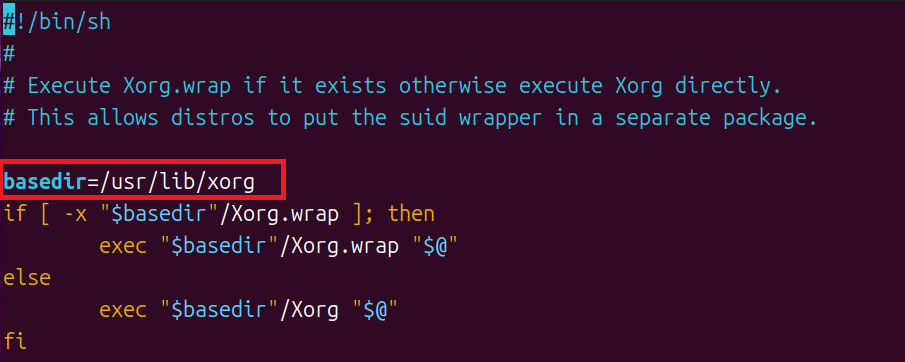

#### 第四步，确认引入问题commit
回退步骤有两种：
   a. 在不发生的那版驱动环境下，按照引入时间顺序，逐笔安装KMD，遇到发生的情况，那笔KMD就是引入问题的；如果一直不发生，继续逐笔安装UMD，遇到发生的情况，那笔UMD就是引入问题的；
   b. 在发生的那版驱动环境下，按照引入时间顺序的倒序，逐笔安装KMD，遇到不发生的情况，那笔KMD时间上的下一笔就是引入问题的那笔；如果一直发生，继续逐笔安装UMD，遇到不发生的情况，那笔UMD时间上的下一笔就是引入问题的；

check kmd、umd是否替换成功，即检查kmd、umd commit info；
   


KMD：

kmd_commit=$(sudo grep "Driver Version" /sys/kernel/debug/musa/version|awk -F[ '{print $NF}'|awk -F] '{print $1}')

或者是开机后查看 dmesg|grep "MTGPU Driver Version" （这种方式查看，如果dmesg被冲掉的话，就无法查询到）；

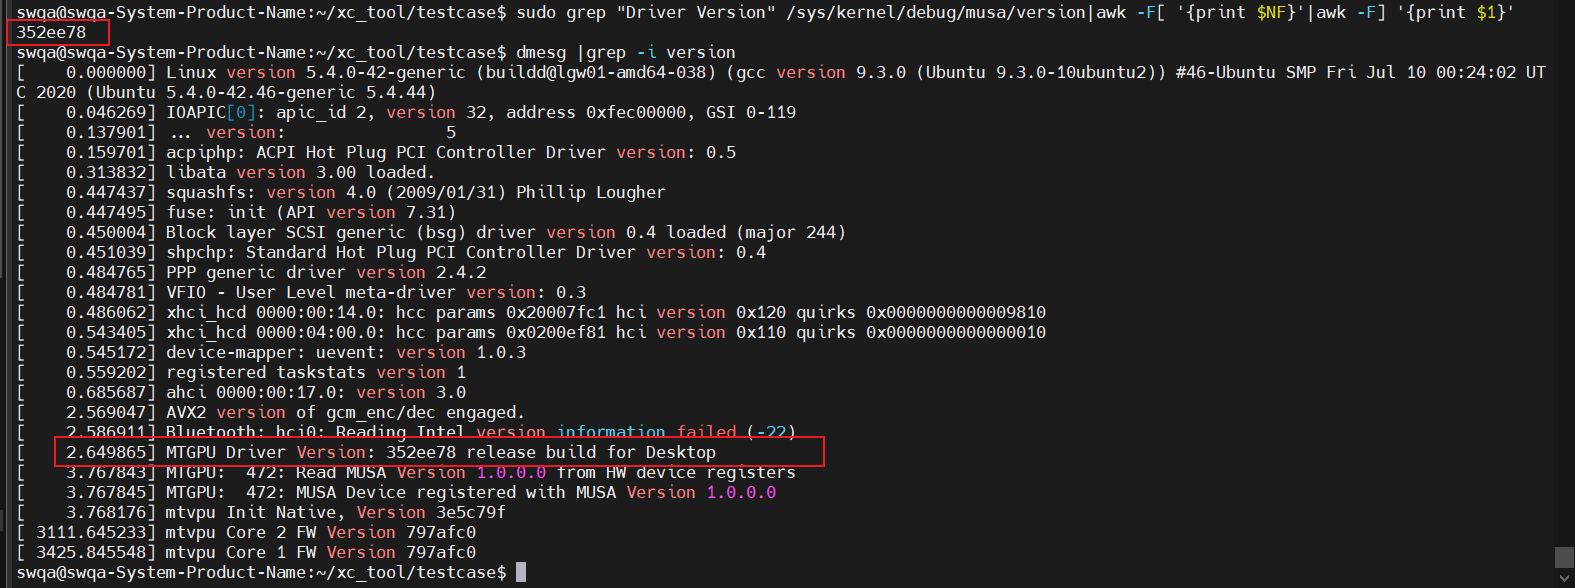

UMD：
适用于develop（24.03.01）
umd_commit=$(export DISPLAY=:0.0 && glxinfo -B |grep -i "OpenGL version string"|awk '{print $NF}'|awk -F "@" '{print $1}')

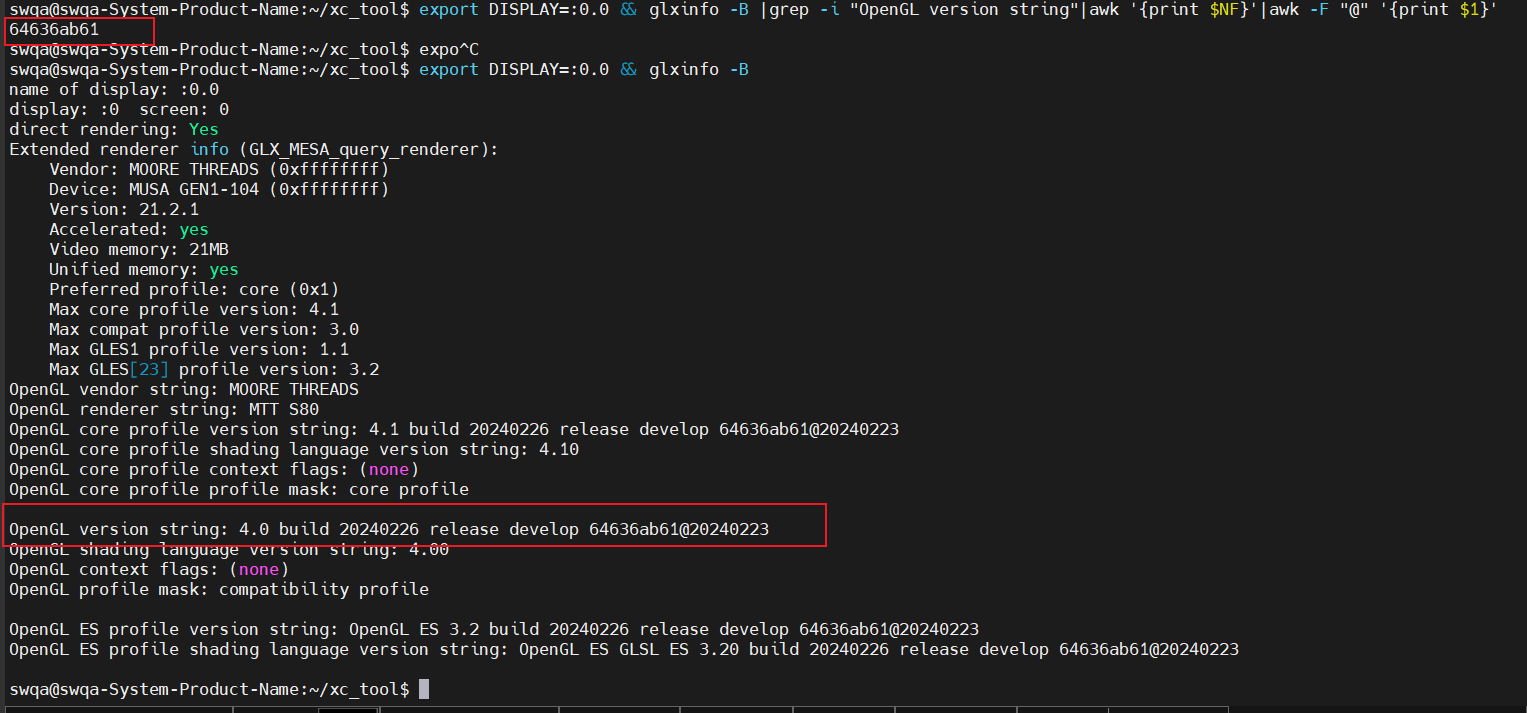

#### 安装后显示器未点亮的情况，检查系统，定位问题

##### 1. 检查mtgpu.ko是否加载
lsmod |grep mtgpu 

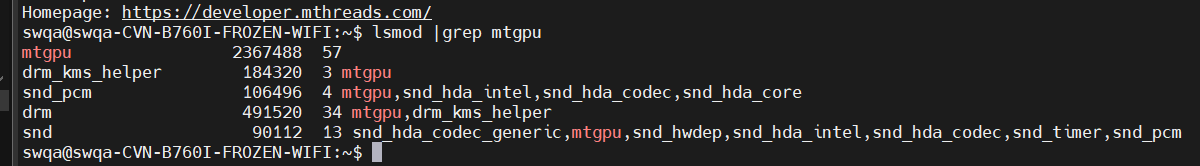

##### 2. 检查Xorg状态
systemctl status lightdm
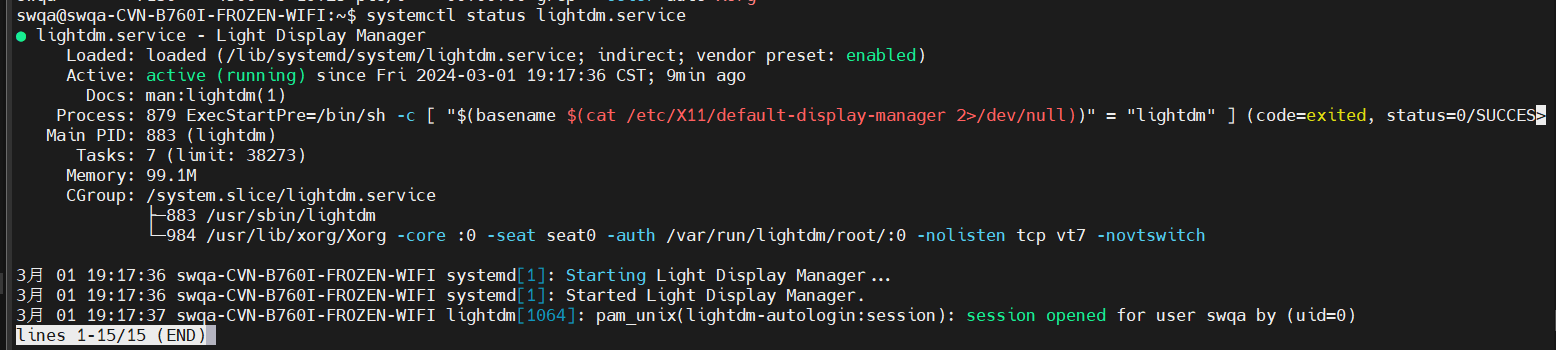

ps -ef |grep Xorg 
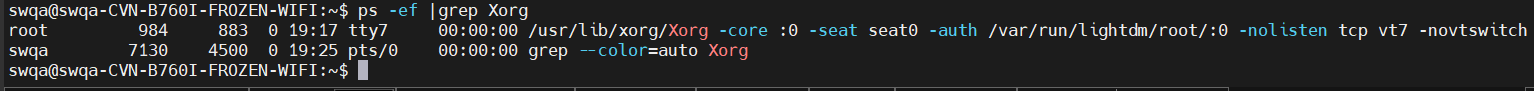

ls /dev/dri
需要有KMD生成card0节点生成，才能成功启动Xorg；

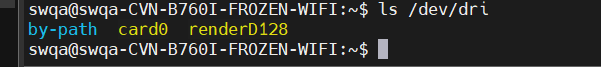

vim /var/log/Xorg.0.log

正常显示时，mtgpu应作为boot vga启动Xorg，日志打印应为mtgpu(0);并且使用的是/dev/dri/card0 node;

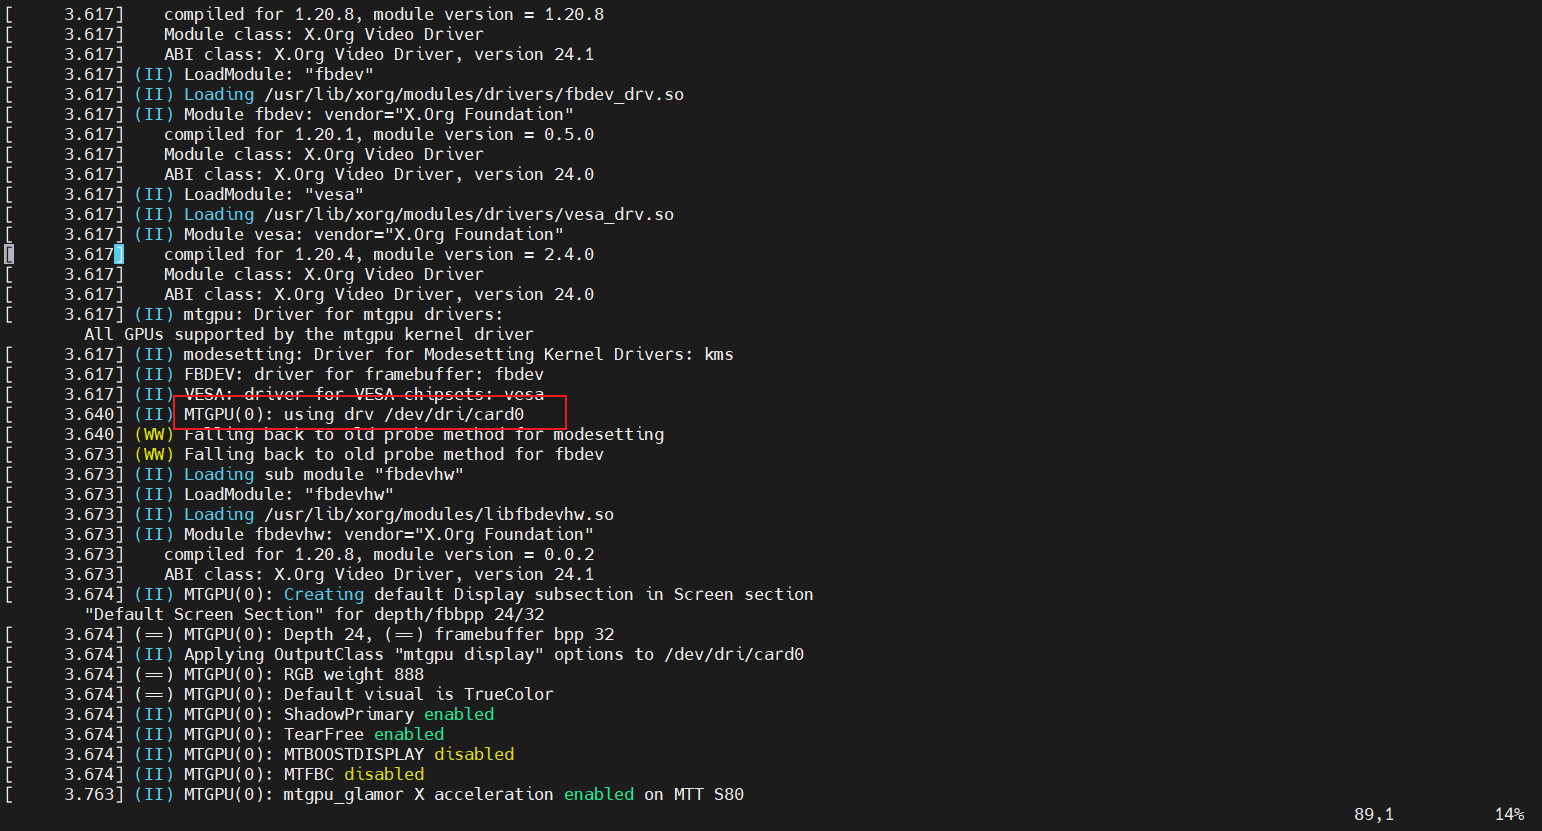

驱动安装步骤：
1. UMD安装
2. KMD安装
3. 配置ko启动参数  /etc/modprobe.d/mtgpu.conf 
4. mtvpu、gmi、pes等其他模块